The simplest nontrivial Kalman filter for 1D motion with no rotation. 

When running this, some of the cells below that perform the actual kalman filtering need to be run twice. Once with the GNSS updates turned off, and a second time with the GNSS updates turned on

In [2]:
import numpy as np
import matplotlib.pyplot as plt

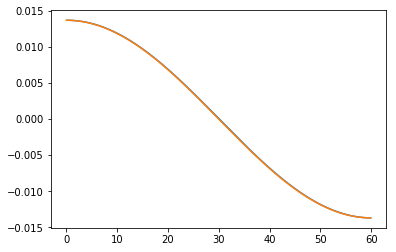

In [91]:
TOTAL_DISTANCE = 10 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = 1 # meter
ACCELEROMETER_RMS_ERROR = 1000e-6*9.8 * np.sqrt(SAMPLING_RATE) # m/s**2

number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE

t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_acceleration = TOTAL_DISTANCE / 2 * np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))**2
true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
true_position = TOTAL_DISTANCE * np.sin(2*np.pi*t / (4*TOTAL_SECONDS))**2

plt.plot(t[2:], np.diff(np.diff(true_position)) / dt**2)
plt.plot(t, true_acceleration)

In [105]:
np.random.seed(42)
sensor_position = np.nan * np.empty(*true_position.shape)
sensor_position_ = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR
sensor_position[::SAMPLING_RATE] = sensor_position_[::SAMPLING_RATE]
sensor_acceleration = true_acceleration + np.random.randn(number_of_timesteps) * ACCELEROMETER_RMS_ERROR

In [106]:
position_estimate_gps_only = sensor_position
position_estimate_accelerometer_only = np.cumsum(np.cumsum(sensor_acceleration)) * dt**2

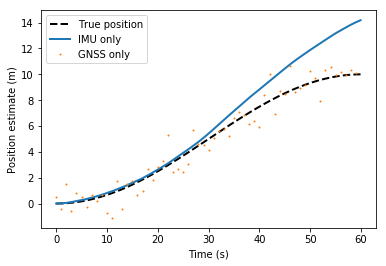

In [107]:
plt.plot(t, true_position, color='black', ls='dashed', lw=2, label='True position')
plt.plot(t, position_estimate_accelerometer_only, lw=2, label='IMU only')
plt.plot(t, position_estimate_gps_only, '.', label='GNSS only', markersize=2)

plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position estimate (m)')
plt.savefig('images/1d-accelerometer-simulation.png', dpi=300)

In [108]:
F = np.array([
    [1, dt],
    [0, 1],
])

Q = np.array([
    [ACCELEROMETER_RMS_ERROR * dt**2 / 2, 0],
    [0, ACCELEROMETER_RMS_ERROR * dt],
]) ** 2 

#Q = np.array([
#    [ACCELEROMETER_RMS_ERROR * dt**2 / 2, 0, 0],
#    [0, ACCELEROMETER_RMS_ERROR * dt, 0],
#    [0, 0, ACCELEROMETER_RMS_ERROR]
#]) ** 2 

R = np.array([
    [GPS_RMS_ERROR, ]
]) ** 2

H = np.array([
    [1, 0],
])

B = np.array([
    [dt**2/2], [dt]
])

P = Q + R



In [116]:
kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

I = np.identity(2)

# initialize state
mu = np.array([0, 0])
P = np.array([
    [GPS_RMS_ERROR**2, 0],
    [0, 0],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    u = np.array([sensor_acceleration[time_index]])
    z = np.array([sensor_position[time_index]])

    #print(z)
    
    # Predict
    mu = F @ mu + B @ u
    P = F @ P @ F.T + Q

    if not np.isnan(z): 
        # Update
        y = z - H @ mu # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        #print(time_index, K)
        mu = mu + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual
    
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
#kalman_index = 0 
#plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


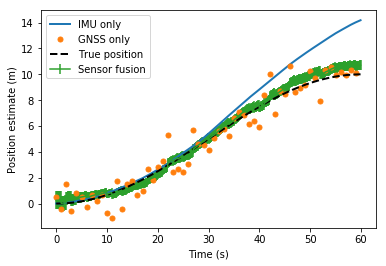

In [115]:
plt.plot(t, position_estimate_accelerometer_only, lw=2, label='IMU only')
plt.plot(t, position_estimate_gps_only, '.', label='GNSS only', markersize=10)
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index], label='Sensor fusion')
plt.plot(t, true_position, color='black', ls='dashed', lw=2, label='True position')

plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position estimate (m)')
plt.savefig('images/1d-accelerometer-simulation.png', dpi=300)



In [117]:
kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

I = np.identity(2)

# initialize state
mu = np.array([0, 0])
P = np.array([
    [GPS_RMS_ERROR**2, 0],
    [0, 0],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    u = np.array([sensor_acceleration[time_index]])
    z = np.array([sensor_position[time_index]])

    #print(z)
    
    # Predict
    mu = F @ mu + B @ u
    P = F @ P @ F.T + Q

    simulated_outage = (t[time_index] > 10 and t[time_index] < 40)
        
    if not np.isnan(z) and not simulated_outage: 
        # Update
        y = z - H @ mu # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        #print(time_index, K)
        mu = mu + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual
    
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
#kalman_index = 0 
#plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)


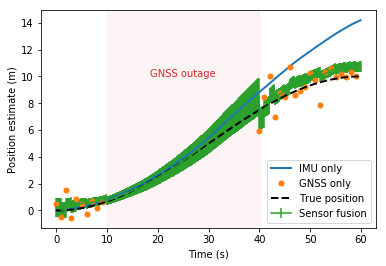

In [128]:
plt.axvspan(10, 40, color='tab:red', alpha=.05)
plt.text(25, 10, ha='center', s='GNSS outage', color='tab:red')

plt.plot(t, position_estimate_accelerometer_only, lw=2, label='IMU only')
valid_range = np.concatenate((np.arange(0,10), np.arange(40, 60))) * SAMPLING_RATE
plt.plot(t[valid_range], position_estimate_gps_only[valid_range], '.', label='GNSS only', markersize=10)
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index], label='Sensor fusion')
plt.plot(t, true_position, color='black', ls='dashed', lw=2, label='True position')

plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position estimate (m)')
plt.savefig('images/1d-accelerometer-simulation-with-simulated-outage.png', dpi=300)

